Author:  Hao Jiang
## Goal for this notebook
Based on version1 data cleaning. This notebook tries to;
 * Further explore the data
 * Try some feature engineering
And the basic idea here's to make the model simple and try to reduce numbers of feats

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
# train.shape
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# combine the data and take all of the feature. This is for easier feature engineering. 
all_data = pd.concat((train.iloc[:,1:-1], test.iloc[:,1:]))
y = np.log1p(train["SalePrice"])
y2 = np.log1p(train["SalePrice"] - train["MiscVal"])

# remember the length of train data
trainLen = len(train)

## Continous data wrangling

Due to previous prediction, we could see that living area and other area infomation is a crucial predictor to final sold price. Insteed of the sold price, price per SF could be a better feature to compare the effect of other features. But first, we need to have some conversions on these continuouse data.  
To begin with, we can see that GrLivArea = 1stFlrSF + 2ndFlrSF, TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF. So if seems better to reduce the features here.

In [4]:
# There is a na TotalBsmtSF value in the test set for 
all_data.loc[:,'TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)

all_data.loc[:,'TotalLivArea'] = all_data.loc[:,'GrLivArea'] + all_data.loc[:,'TotalBsmtSF']
all_data['TotalPorchSF'] = all_data[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis = 1)
YPerSF = np.log1p((train["SalePrice"] - train["MiscVal"]) / all_data[:trainLen]['TotalLivArea'])

In [5]:
continuous_feats = pd.Index([name for name in all_data.columns if "Area" in name or "SF" in name or 'Porch' in name])
all_data.loc[:, continuous_feats] = np.log1p(all_data[continuous_feats])
len(continuous_feats)

19

In [6]:
matplotlib.rcParams['figure.figsize'] = (12.0, 18.0)

# Non zeor non null histogram
# for i in range(len(continuous_feats)):
#     plt.subplot(np.ceil(np.sqrt(len(continuous_feats))),np.floor(np.sqrt(len(continuous_feats))), i + 1)
#     temp_val = np.log1p(all_data[:trainLen][continuous_feats[i]])
#     plt.scatter(x = temp_val[temp_val > 0], y = y2[temp_val > 0],s = 10)
#     plt.title(continuous_feats[i])

That's check the relationship between continuous value and SalePrice
* The followering are strongly correlated:
 * 1stFlrSF, 2ndFlrSF, BsmtFinSF1, BsmtFinSF2, GrLivArea, GarageArea, TotalBsmtSF, TotalLivArea
* The followering are kinda correlated:
 * LotArea, MasVnr
* Several has too little samples and are difficult to decide
 * 3SsnPorch, LowQualFinSF, PoolArea
* The rest and kinda none-related ones
 * BsmtFinSF2, BsmtUnfSF, OpenPorchSF, ScreenPorch, WoodDeckSF, TotalPorchSF

So what we will do here now is to drop those few sample features and seemly non-correlated features.  
For the correlated ones we are still gonna drop some like 1stFlrSF because it is strongly correlated to TotalLivArea.
BsmtFinSF1 seems to has to different group, which might due to large BsmtFinSF2 area. So will just ignore that.

## Discrete Data

In [7]:
YrFeats = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt','MoSold', 'YrSold']

matplotlib.rcParams['figure.figsize'] = (16.0,12.0)
# for i in range(len(YrFeats)):
#     plt.subplot(3,2, i + 1)
#     temp_val = all_data[:trainLen][YrFeats[i]]
#     plt.scatter(x = temp_val[temp_val > 0], y = YPerSF[temp_val > 0],s = 10)
#     plt.title(YrFeats[i])

No much difference between Price per SF on YearSold, so we will just leave the Year data as they are and drop year.
As for month, we might expect some seasonal difference here.

In [8]:
# SeasonalFeat = ['Heating', 'HeatingQC', 'FireplaceQu', 'Fireplaces', 'CentralAir', 'PoolQC', '3SsnPorch', 'ScreenPorch']
SeasonalFeat = ['Heating', 'HeatingQC', 'FireplaceQu', 'Fireplaces', 'CentralAir', 'PoolQC']
matplotlib.rcParams['figure.figsize'] = (18.0,18.0)
# for i in range(len(SeasonalFeat)):
#     plt.subplot(3,2,i + 1)
#     sns.boxplot(x = all_data[:trainLen]['MoSold'], y = YPerSF,hue = all_data[:trainLen][SeasonalFeat[i]])
#     plt.title(SeasonalFeat[i])

Not much correlation between Month and price, so we'll just ignore MoSold

In [9]:
# Discrete
discreteFeats = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                 'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars']
matplotlib.rcParams['figure.figsize'] = (18.0,15.0)
# for i in range(len(discreteFeats)):
#     plt.subplot(3,3,i + 1)
#     sns.boxplot(x = all_data[:trainLen][discreteFeats[i]], y = YPerSF)

Several features does not seems to matter:
 * BsmtFullBath, BsmtHalfBath, TotRmsAbvGrid

We will simply leave the others as they are, but we do want to add several feats to describe the non-linear party.

In [10]:
all_data['HasMultiHalfBath'] = all_data['HalfBath'] > 1
all_data['Morethan2Fireplace'] = all_data['Fireplaces'] > 2
all_data['Morethan3Cars'] = all_data['GarageCars'] > 3

## Ordinal data
Basically that's all for continuous data. Now that's convert Ordinal ones.

In [11]:
# LotShape
all_data['LotShape'] = all_data['LotShape'].replace(['IR3','IR2','IR1' ,'Reg'], [1,2,3,4])
all_data['LandContour'] = all_data['LandContour'].replace(['Low', 'HLS', 'Bnk','Lvl'], [1,2,3,4])
all_data['Utilities'] = all_data['Utilities'].replace(['ELO','NoSeWa','NoSewr','AllPub'], [1,2,3,4])
all_data['LandSlope'] = all_data['LandSlope'].replace(['Sev' , 'Mod', 'Gtl'], [1,2,3])
all_data['ExterQual'] = all_data['ExterQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['ExterCond'] = all_data['ExterCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['BsmtQual'] = all_data['BsmtQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['BsmtCond'] = all_data['BsmtCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['BsmtExposure'] = all_data['BsmtExposure'].replace(['No', 'Mn', 'Av', 'Gd'], [1,2,3,4])
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].replace(['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [1,2,3,4,5,6])
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].replace(['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [1,2,3,4,5,6])
all_data['HeatingQC'] = all_data['HeatingQC'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['KitchenQual'] = all_data['KitchenQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['Functional'] = all_data['Functional'].replace(['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'], [
        1,2,3,4,5,6,7,8])
all_data['FireplaceQu'] = all_data['FireplaceQu'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['GarageFinish'] = all_data['GarageFinish'].replace(['Unf', 'RFn', 'Fin'], [1,2,3])
all_data['GarageQual'] = all_data['GarageQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['GarageCond'] = all_data['GarageCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['PoolQC'] = all_data['PoolQC'].replace(['Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4])
all_data['Fence'] = all_data['Fence'].replace(['MnWw', 'GdWo', 'MnPrv', 'GdPrv'], [1,2,3,4])
all_data['CentralAir'] = all_data['CentralAir'].replace(['N', 'Y'], [0,1])

In [12]:
# Ordinal check
ord_feats = pd.Index(['LotShape','LandContour','Utilities','LandSlope',
                      'OverallQual','OverallCond','ExterQual','ExterCond',
                      'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                      'BsmtFinType2','HeatingQC','KitchenQual','Functional',
                      'FireplaceQu','GarageFinish','GarageQual','GarageCond',
                      'PoolQC','Fence', 'CentralAir'])
all_data.loc[:,ord_feats] = all_data[ord_feats].fillna(0)

In [13]:
# Not let's check the boxplot of these values to price per sf
matplotlib.rcParams['figure.figsize'] = (12.0, 24.0)

# Non zeor non null histogram
# for i in range(len(ord_feats)):
#     plt.subplot(6,4, i + 1)
#     sns.boxplot(y = YPerSF, x = all_data[:trainLen][ord_feats[i]])

Feats to ignore:
 * LandSlope
 * BsmtFinType1 & 2 (due to difficulties of inperpretation)  
 * LandContour (due to difficulties of inperpretation)  
 * Fence (does not seems to have big difference)
 
Most of the other's would be referenced and added some extra feats

In [14]:
all_data['LotShape-IR3'] = (all_data['LotShape'] == 1) * 1
all_data['LowOverAllQual'] = (all_data['OverallQual'] < 4) * 1
all_data['AvgOverAllCond'] = (all_data['OverallCond'] == 5) * 1
all_data['TypExterCond'] = (all_data['ExterCond'] == 3) * 1

## Nominal data

Finally let's fill in na data and one-hot encoding nomincal ones

In [15]:
NomFeats = ['MSZoning','Street','Alley','Neighborhood','Condition1','Condition2',
            'BldgType','HouseStyle','MSSubClass','RoofStyle','RoofMatl','Exterior1st',
            'Exterior2nd','Foundation','Heating','Electrical','Functional','GarageType',
            'PavedDrive','MiscFeature','SaleType','LotConfig','MasVnrType','SaleCondition']
len(NomFeats)

24

In [16]:
# Deal with Exterior
for name in all_data["Exterior1st"].dropna().unique():
    all_data['Exterior-' + name] = 1 * ((all_data["Exterior1st"] == name) | (all_data["Exterior2nd"] == name))

# Deal with Condition
for name in all_data["Condition1"].dropna().unique():
    all_data['Condition-' + name] = 1 * ((all_data["Condition1"] == name) | (all_data["Condition2"] == name))

In [17]:
all_data.loc[:,'MSSubClass'] = all_data.loc[:,'MSSubClass'].astype('category')

In [18]:
# Not let's check the boxplot of these values to price per sf
matplotlib.rcParams['figure.figsize'] = (12.0, 24.0)

# Non zeor non null histogram
# for i in range(len(NomFeats)):
#     plt.subplot(6,4, i + 1)
#     sns.boxplot(y = YPerSF, x = all_data[:trainLen][NomFeats[i]])

In [19]:
all_data = pd.get_dummies(all_data)

In [20]:
# check na value count
nullCnt = pd.DataFrame({'nullNums' : all_data.isnull().sum()})
nullCnt['DataType'] = all_data[nullCnt.index].dtypes
print nullCnt[nullCnt['nullNums'] > 0].sort_values(by = 'DataType')

              nullNums DataType
LotFrontage        486  float64
MasVnrArea          23  float64
BsmtFinSF1           1  float64
BsmtFinSF2           1  float64
BsmtUnfSF            1  float64
BsmtFullBath         2  float64
BsmtHalfBath         2  float64
GarageYrBlt        159  float64
GarageCars           1  float64
GarageArea           1  float64


Based on previous data cleaning we know that we should fill in LatFrontage data.  
For GaBltyears, we will just set them to 999

In [21]:
all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = all_data['GarageYrBlt'].min()
all_data = all_data.fillna(0)

In [22]:
# Drop features
# Continous ones
# all_data = all_data.drop(['TotalBsmtSF', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'OpenPorchSF', 'WoodDeckSF', 
#                           'TotalPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
#                           'LowQualFinSF', 'PoolArea', 'GrLivArea','1stFlrSF', '2ndFlrSF', 
#                           'LotFrontage', 'MiscVal', 'LotFrontage'], axis = 1)
# # Discrete ones
# all_data = all_data.drop(['MoSold', 'BsmtFullBath', 'BsmtHalfBath', 'TotRmsAbvGrd'], axis = 1)
# # Ordinal ones
# all_data = all_data.drop(['LandSlope', 'BsmtFinType1', 'BsmtFinType2', 'LandContour', 'Fence'], axis = 1)


In [23]:
# from sklearn.feature_selection import VarianceThreshold
# sel = VarianceThreshold(threshold=(.95 * (1 - .95)))
# # all_data = sel.fit_transform(all_data)
# sel.fit(all_data)
# all_data = pd.DataFrame(data = sel.transform(all_data), columns = all_data.columns[sel.get_support()])

In [24]:
# all_data.shape
all_data.head()

,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,9.042040,4,4,4.0,3,7,5,2003,2003,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9.169623,4,4,4.0,3,6,8,1976,1976,...,0,0,0,1,0,0,0,0,1,0
2,68.0,9.328212,3,4,4.0,3,7,5,2001,2002,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9.164401,3,4,4.0,3,7,5,1915,1970,...,0,0,0,1,1,0,0,0,0,0
4,84.0,9.565284,3,4,4.0,3,8,5,2000,2000,...,0,0,0,1,0,0,0,0,1,0


In [25]:
X_train = all_data[:trainLen]
X_test = all_data[trainLen:]

### Basic Regression
Try and see Lasso and Ridge. Use all the features to predict log1p(SalePrice) directly.

In [26]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [27]:
# Search or the best result for ridge

ridge_param_test = {
    'alpha':[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
}

ridge_search = GridSearchCV(
    estimator = Ridge(),
    param_grid = ridge_param_test, 
    scoring='neg_mean_squared_error',
    n_jobs=1,
    iid=False, 
    cv=5
)
ridge_search.fit(X_train,y)
(zip(np.sqrt(-ridge_search.cv_results_['mean_test_score']),ridge_search.cv_results_['params']) ,
 ridge_search.best_params_, np.sqrt(- ridge_search.best_score_))

([(0.14088162313509162, {'alpha': 0.05}),
  (0.13950120087683729, {'alpha': 0.1}),
  (0.13646730871408527, {'alpha': 0.3}),
  (0.13242427910190757, {'alpha': 1}),
  (0.12912834206646961, {'alpha': 3}),
  (0.12807494668620611, {'alpha': 5}),
  (0.12736079161359956, {'alpha': 10}),
  (0.12741745926709555, {'alpha': 15}),
  (0.12857748306198263, {'alpha': 30}),
  (0.13044666750264067, {'alpha': 50}),
  (0.1325658723358768, {'alpha': 75})],
 {'alpha': 10},
 0.12736079161359956)

In [28]:
lasso_param_test = {
#     'alpha':[0.0001,0.0003,0.0005,0.001,0.005,0.01,0.05]
    'alpha':np.arange(0.0003,0.001,0.00005)
}

lasso_search = GridSearchCV(
    estimator = Lasso(),
    param_grid = lasso_param_test, 
    scoring='neg_mean_squared_error',
    n_jobs=4,
    iid=False, 
    cv=5
)
lasso_search.fit(X_train,y)
(zip(np.sqrt(-lasso_search.cv_results_['mean_test_score']),lasso_search.cv_results_['params'])
 ,lasso_search.best_params_, np.sqrt(- lasso_search.best_score_))

([(0.1234656347023905, {'alpha': 0.00029999999999999997}),
  (0.12307207847136895, {'alpha': 0.00035}),
  (0.12285097981416801, {'alpha': 0.00040000000000000002}),
  (0.12267594585922728, {'alpha': 0.00045000000000000004}),
  (0.1225484580477444, {'alpha': 0.00050000000000000001}),
  (0.12248564752108007, {'alpha': 0.00055000000000000014}),
  (0.12250667012076299, {'alpha': 0.00060000000000000006}),
  (0.12259459764203114, {'alpha': 0.00065000000000000019}),
  (0.12271074020560607, {'alpha': 0.0007000000000000001}),
  (0.12286783871335469, {'alpha': 0.00075000000000000023}),
  (0.12305640755075976, {'alpha': 0.00080000000000000015}),
  (0.12328698468352453, {'alpha': 0.00085000000000000028}),
  (0.12350974333958517, {'alpha': 0.00090000000000000019}),
  (0.12372960637082267, {'alpha': 0.00095000000000000032}),
  (0.12398600541649839, {'alpha': 0.0010000000000000002})],
 {'alpha': 0.00055000000000000014},
 0.12248564752108007)

In [29]:
model_lasso = Lasso(alpha = 0.00055)
model_lasso.fit(X_train, y)

Lasso(alpha=0.00055, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
lassoCoef = pd.Series(model_lasso.coef_, index = X_train.columns)
nonZeroLasso = lassoCoef[lassoCoef != 0].index
nonZeroLasso.shape

(100,)

### KNN regressor

In [34]:
from sklearn.neighbors.regression import KNeighborsRegressor

In [65]:
# Search or the best result for knn

knn_param_test = {
#     'n_neighbors' : range(3,22,3)
#     'n_neighbors' : range(4,10,1)
}

knn_search = GridSearchCV(
    estimator = KNeighborsRegressor(
        n_jobs = 4,
        n_neighbors = 7,
        weights = 'distance'        
    ),
    param_grid = knn_param_test, 
    scoring='neg_mean_squared_error',
    n_jobs=1,
    iid=False,
    cv=5
)
knn_search.fit(X_train[nonZeroLasso],y)
(zip(np.sqrt(-knn_search.cv_results_['mean_test_score']),
    knn_search.cv_results_['params']), 
 knn_search.best_params_,np.sqrt(-knn_search.best_score_))

([(0.25387808468723133, {'n_neighbors': 3}),
  (0.24079872715418701, {'n_neighbors': 6}),
  (0.2408778787204939, {'n_neighbors': 9}),
  (0.24228179793525739, {'n_neighbors': 12}),
  (0.24450235605528742, {'n_neighbors': 15}),
  (0.24582112642956, {'n_neighbors': 18}),
  (0.24678948167468301, {'n_neighbors': 21})],
 {'n_neighbors': 6},
 0.24079872715418701)

In [35]:
from sklearn.model_selection import cross_val_score
# First let's see best numbers of feats without weight setting

lassoFeatsWeight = abs(lassoCoef[lassoCoef != 0]).sort_values()
lassoFeatsRescale = abs(X_train[lassoCoef[lassoCoef != 0].index].mean() * lassoCoef[lassoCoef != 0]).sort_values()

In [68]:
# for i in range(10,91,10):
for i in range(46,55,1):
    topi_score = cross_val_score(
        estimator = KNeighborsRegressor(
            n_jobs = 4,
            n_neighbors = 7,
            weights = 'distance'        
        ),
        X = pd.DataFrame(X_train[lassoFeatsRescale.tail(i).index].values * lassoFeatsWeight[lassoFeatsRescale.tail(i).index].values,columns = lassoFeatsRescale.tail(i).index),
        y = y,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        cv = 5,
    )
    print i, np.sqrt(-topi_score).mean()


46 0.138065664791
47 0.138031650951
48 0.138082828446
49 0.138177399243
50 0.136068617496
51 0.135576150979
52 0.135995450342
53 0.135302107387
54 0.135611530649


Use top 53.

### RandomForest

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
# There were some trials before this. So please ignore the specific range here.
rf_param_test = {
#     "max_features"  : range(10,101,10)
    "max_features"  : range(10,30,2)
}
rf_search = GridSearchCV(
    estimator = RandomForestRegressor(
        n_estimators = 50, 
        random_state = 50,
        max_features = 20,
        warm_start = True,
        n_jobs = 4        
    ),
    param_grid = rf_param_test,
    scoring = 'neg_mean_squared_error',
    n_jobs = 1,
    iid = False,
    cv = 5
)
rf_search.fit(X_train[nonZeroLasso],y)
(zip(np.sqrt(-rf_search.cv_results_['mean_test_score']),
     rf_search.cv_results_['params']), 
 rf_search.best_params_,np.sqrt(-rf_search.best_score_))

([(0.14137380459878759, {'max_features': 10}),
  (0.13832138422884069, {'max_features': 12}),
  (0.13842689779356768, {'max_features': 14}),
  (0.13928150367919903, {'max_features': 16}),
  (0.13770080425727904, {'max_features': 18}),
  (0.13753420972936692, {'max_features': 20}),
  (0.13696519555973349, {'max_features': 22}),
  (0.13860913620463827, {'max_features': 24}),
  (0.13659258994088541, {'max_features': 26}),
  (0.13833734416533519, {'max_features': 28})],
 {'max_features': 26},
 0.13659258994088541)

In [47]:
rf_score = cross_val_score(
    estimator = RandomForestRegressor(
        n_estimators = 500, 
        random_state = 100,
        max_features = 20,
        n_jobs = 4
    ),
    X = X_train[nonZeroLasso],
    y = y,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    cv = 5
)
print np.sqrt(-rf_score).mean()

0.135058692699


### Xgboost

In [37]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [38]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields HasMultiHalfBath, KNNPred, LassoPred, Morethan2Fireplace, Morethan3Cars, RFPred, XGBPred

In [58]:
# All tuning would be done within this cell
xgb_param_test = {
#     'max_depth':range(3,6,1),
#     'min_child_weight':range(1,5,1)
#     'gamma' : [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
#     'gamma' : np.arange(0.007, 0.02, 0.0005)
#     'subsample': np.arange(0.4, 0.6, 0.03),
#     'colsample_bytree': np.arange(0.2, 0.4, 0.03)
#     'reg_alpha' : [1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2]
    'reg_alpha' : np.arange(0.005,0.03,0.0025) # 8.2e-6
#     'reg_lambda' : np.arange(0.7,1.1,0.03)
}
xgb_search = GridSearchCV(
    estimator = XGBRegressor(
        learning_rate =0.1,
        n_estimators=140,
        max_depth=4,
        min_child_weight=2,
        gamma=0.009,
        subsample=0.58,
        colsample_bytree=0.38,
        objective= 'reg:linear',
        nthread=4,
        reg_alpha = 0.0125,
        seed=100
    ),
    param_grid = xgb_param_test,
    scoring = 'neg_mean_squared_error',
    n_jobs = 1,
    iid = False,
    cv = 5
)
xgb_search.fit(X_train[nonZeroLasso], y)
(zip(np.sqrt(-xgb_search.cv_results_['mean_test_score']),xgb_search.cv_results_['params']),
 xgb_search.best_params_,np.sqrt(- xgb_search.best_score_))

([(0.1200493418214074, {'reg_alpha': 0.0050000000000000001}),
  (0.12000643957779271, {'reg_alpha': 0.0074999999999999997}),
  (0.12049858977267638, {'reg_alpha': 0.0099999999999999985}),
  (0.11970979284371609, {'reg_alpha': 0.012499999999999999}),
  (0.12028586657682794, {'reg_alpha': 0.014999999999999999}),
  (0.12165338276519184, {'reg_alpha': 0.017499999999999998}),
  (0.12110432468602933, {'reg_alpha': 0.019999999999999997}),
  (0.12215944032733815, {'reg_alpha': 0.022499999999999999}),
  (0.12211601995173445, {'reg_alpha': 0.024999999999999998}),
  (0.12227959062732006, {'reg_alpha': 0.027499999999999997})],
 {'reg_alpha': 0.012499999999999999},
 0.11970979284371609)

In [62]:
xgb_score = cross_val_score(
    estimator = XGBRegressor(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=2,
        gamma=0.009,
        subsample=0.58,
        colsample_bytree=0.38,
        objective= 'reg:linear',
        nthread=4,
        reg_alpha = 0.0125,
        seed=100
    ),
    X = X_train[nonZeroLasso],
    y = y,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    cv = 10
)
print np.sqrt(-xgb_score).mean()

0.114052444224


### Model stacking

In [39]:
from sklearn.model_selection import KFold

In [40]:
# Add fields into all_data in advance
X_train = pd.concat((X_train, pd.DataFrame(columns = ['LassoPred', 'XGBPred', 'KNNPred', 'RFPred'])))

In [41]:
# model_lasso 

model_knn = KNeighborsRegressor(  # use ridge top 64 weighted features
    n_jobs = 4,
    n_neighbors = 7,
    weights = 'distance'
)
model_rf = RandomForestRegressor( #use lasso_coef none zero features
    n_estimators = 500, 
    random_state = 100,
    max_features = 20,
    n_jobs = 4
)
model_xgb = XGBRegressor( # use all features
    learning_rate =0.01,
    n_estimators=5000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.009,
    subsample=0.58,
    colsample_bytree=0.38,
    objective= 'reg:linear',
    nthread=4,
    reg_alpha = 0.0125,
    seed=100
)

In [42]:
kf = KFold(n_splits = 5)
knnIndex = lassoFeatsRescale.tail(53).index;
for train_index, test_index in kf.split(X_train):
    model_lasso.fit(X_train.loc[train_index,nonZeroLasso], y.loc[train_index])
    model_knn.fit(pd.DataFrame(X_train[knnIndex].values * lassoFeatsWeight[knnIndex].values,columns = knnIndex).loc[train_index,:], y.loc[train_index])
    model_rf.fit(X_train.loc[train_index,nonZeroLasso], y.loc[train_index])
    model_xgb.fit(X_train.loc[train_index,nonZeroLasso], y.loc[train_index])
    X_train.loc[test_index,'LassoPred'] = model_lasso.predict(X_train.loc[test_index,nonZeroLasso])
    X_train.loc[test_index,'XGBPred']   = model_knn.predict(pd.DataFrame(X_train[knnIndex].values * lassoFeatsWeight[knnIndex].values,columns = knnIndex).loc[test_index,:])
    X_train.loc[test_index,'KNNPred']   = model_rf.predict(X_train.loc[test_index,nonZeroLasso])
    X_train.loc[test_index,'RFPred']    = model_xgb.predict(X_train.loc[test_index,nonZeroLasso])

In [46]:
X_train[['LassoPred', 'XGBPred', 'KNNPred', 'RFPred']].head()

,LassoPred,XGBPred,KNNPred,RFPred
0,12.2489,12.2693,12.2458,12.2333
1,12.1839,12.0595,12.0396,12.0675
2,12.2912,12.266,12.2666,12.2517
3,12.1032,12.1834,12.0576,12.1157
4,12.6375,12.6161,12.5286,12.5446


In [48]:
model_lasso.fit(X_train[nonZeroLasso], y)
model_knn.fit(pd.DataFrame(X_train[knnIndex].values * lassoFeatsWeight[knnIndex].values,columns = knnIndex), y)
model_rf.fit(X_train[nonZeroLasso], y)
model_xgb.fit(X_train[nonZeroLasso], y)
X_test.loc[:,'LassoPred'] = model_lasso.predict(X_test[nonZeroLasso])
X_test.loc[:,'XGBPred']   = model_knn.predict(pd.DataFrame(X_test[knnIndex].values * lassoFeatsWeight[knnIndex].values,columns = knnIndex))
X_test.loc[:,'KNNPred']   = model_rf.predict(X_test[nonZeroLasso])
X_test.loc[:,'RFPred']    = model_xgb.predict(X_test[nonZeroLasso])

/Users/hao.jiang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/hao.jiang/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [50]:
X_test[['LassoPred', 'XGBPred', 'KNNPred', 'RFPred']].head()

,LassoPred,XGBPred,KNNPred,RFPred
0,11.645086,11.754070,11.729903,11.738897
1,11.943406,11.961389,11.946146,11.989332
2,12.099694,12.190695,12.102585,12.155525
3,12.189622,12.163529,12.118412,12.173773
4,12.220394,12.178928,12.175428,12.118225


In [59]:
temp_train = pd.concat((X_train, pd.DataFrame({'Id' : train.Id, 'SalePrice' : y})),axis=1, join='inner')
temp_test = pd.concat((X_test, pd.DataFrame({'Id' : test.Id})),axis=1, join='inner')

In [62]:
temp_train.tail()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley_Grvl,Alley_Pave,AvgOverAllCond,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,TotalPorchSF,TypExterCond,Utilities,WoodDeckSF,XGBPred,YearBuilt,YearRemodAdd,YrSold,Id,SalePrice
1455,6.860664,6.543912,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,...,3.713572,1.0,4.0,0.000000,12.0695,1999.0,2000.0,2007.0,1456,12.072547
1456,7.637234,0.000000,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,0.000000,1.0,4.0,5.857933,12.2143,1978.0,1988.0,2010.0,1457,12.254868
1457,7.080868,7.050123,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,...,4.110874,0.0,4.0,0.000000,12.4967,1941.0,2006.0,2010.0,1458,12.493133
1458,6.983790,0.000000,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,4.727388,1.0,4.0,5.905362,11.8221,1950.0,1996.0,2010.0,1459,11.864469
1459,7.136483,0.000000,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,4.234107,1.0,4.0,6.602588,11.8377,1965.0,1965.0,2008.0,1460,11.901590


In [63]:
temp_train.to_csv("temp_train.csv", index = False)
temp_test.to_csv("temp_test.csv", index = False)

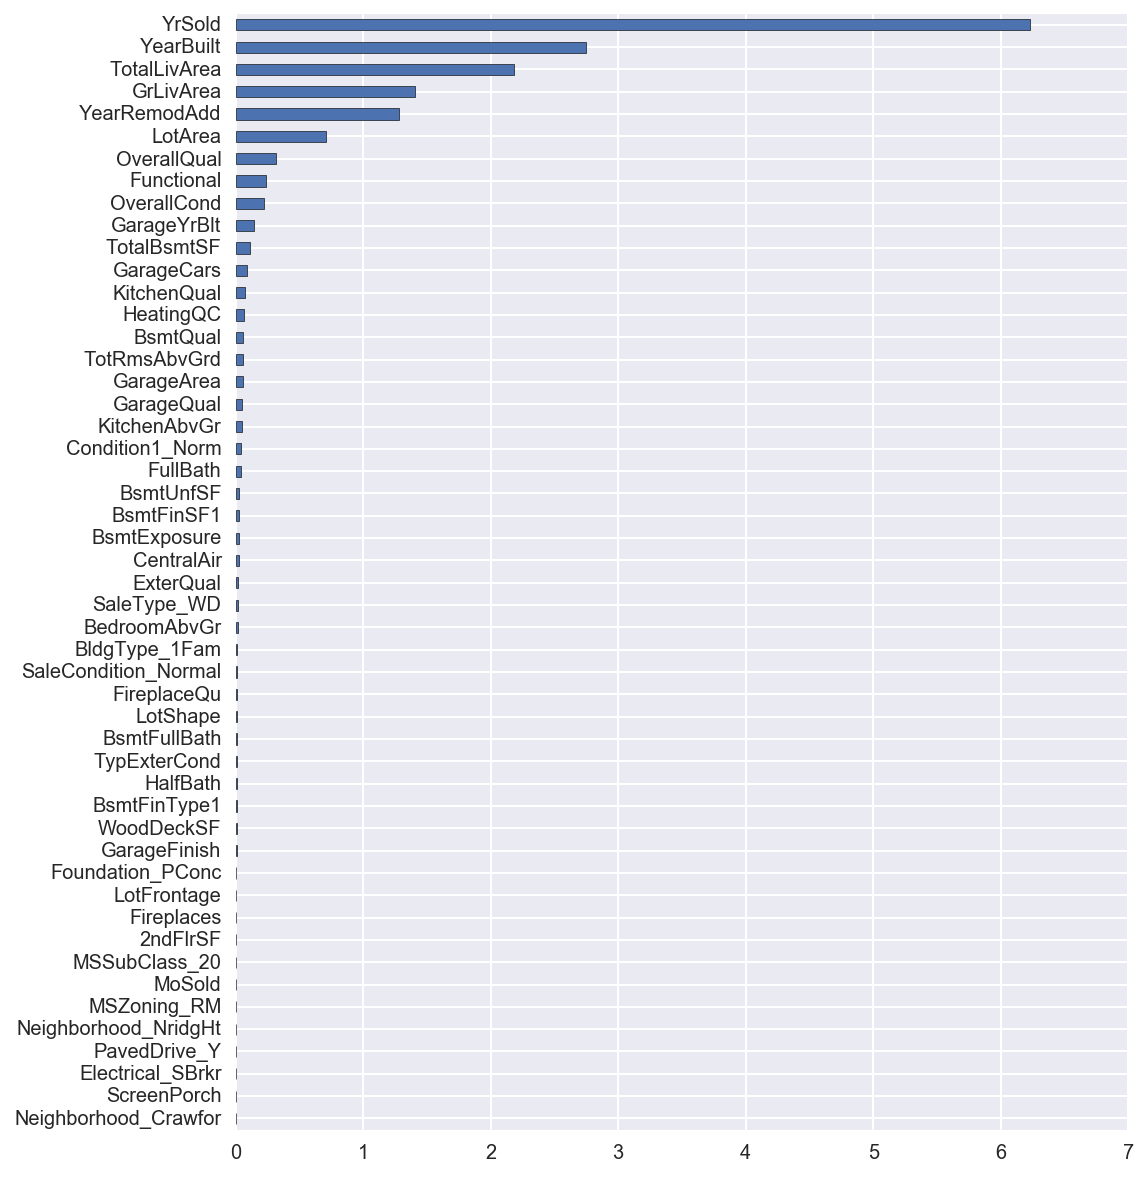

In [64]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
lassoFeatsRescale.tail(50).sort_values().plot(kind = "barh")

### Predict

In [85]:
newTrain = X_train[nonZeroLasso]
predType = X_train[['LassoPred', 'XGBPred', 'KNNPred', 'RFPred']].subtract(y, axis = 0).idxmin(axis = 1)

In [86]:
newTrain.head()

,LotFrontage,LotArea,LotShape,LandContour,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,Heating_GasW,Electrical_SBrkr,GarageType_Detchd,PavedDrive_Y,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal
0,65.0,9.042040,4.0,4.0,7.0,5.0,2003.0,2003.0,5.283204,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,80.0,9.169623,4.0,4.0,6.0,8.0,1976.0,1976.0,0.000000,3.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,68.0,9.328212,3.0,4.0,7.0,5.0,2001.0,2002.0,5.093750,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,60.0,9.164401,3.0,4.0,7.0,5.0,1915.0,1970.0,0.000000,3.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,84.0,9.565284,3.0,4.0,8.0,5.0,2000.0,2000.0,5.860786,4.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [80]:
from sklearn.linear_model import LogisticRegression

In [82]:
logit_model = LogisticRegression(n_jobs = 4)

In [87]:
logit_model.fit(newTrain, predType)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [88]:
newTest = X_test[nonZeroLasso]

In [108]:
predTest = pd.Series(logit_model.predict(newTest),index = X_test.index)

In [118]:
predVal = pd.DataFrame({'Id' : test['Id'], 'SalePrice' : [np.expm1(X_test.iloc[x][predTest[x]]) for x in X_test.index]})
predVal.head()

,Id,SalePrice
0,1461,114128.152514
1,1462,153798.663847
2,1463,196946.960670
3,1464,183213.365395
4,1465,183179.093750


In [119]:
predVal.to_csv('result.csv', index = False)